In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../../source')
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

from BetaUtils import beta_hedging_ret, get_beta
from energy_functions import correlation, neg_returns, volatility
from Hedge import Hedge

import datetime

from plotting_functions import *

## Analyzing Haosu's sector exploration

In [13]:
batch_results_plotter('../Tang/sim0428_tech/portfolios.txt','../Tang/sim0428_tech/result_market.txt',\
                      '../Tang/sim0428_tech/tech_states.txt','2013-10-01','2014-12-31', title="Tech_2014")

Bar plot 0
Bar plot 1
Bar plot 2
Bar plot 3
Bar plot 4
TS_plot 0
TS_plot 1
TS_plot 2
TS_plot 3
TS_plot 4


In [19]:
batch_results_plotter('../Tang/sim0429_consumerdurable/portfolios.txt','../Tang/sim0429_consumerdurable/result_market.txt',\
                      '../Tang/sim0429_consumerdurable/states.txt','2013-10-01','2014-12-31', title="Consumer_Durable_2014")

Bar plot 0
Bar plot 1
Bar plot 2
Bar plot 3
Bar plot 4
TS_plot 0
TS_plot 1
TS_plot 2
TS_plot 3
TS_plot 4


In [21]:
batch_results_plotter('../Tang/sim0429_energy/portfolios.txt','../Tang/sim0429_energy/result_market.txt',\
                      '../Tang/sim0429_energy/states.txt','2013-10-01','2014-12-31', title="Energy_2014")

Bar plot 0
Bar plot 1
Bar plot 2
Bar plot 3
Bar plot 4
TS_plot 0
TS_plot 1
TS_plot 2
TS_plot 3
TS_plot 4


In [23]:
batch_results_plotter('../Tang/sim0429_healthcare/portfolios.txt','../Tang/sim0429_healthcare/result_market.txt',\
                      '../Tang/sim0429_healthcare/states.txt','2013-10-01','2014-12-31', title="Healthcare_2014")

Bar plot 0
Bar plot 1
Bar plot 2
Bar plot 3
Bar plot 4
TS_plot 0
TS_plot 1
TS_plot 2
TS_plot 3
TS_plot 4


In [8]:
batch_results_plotter('Haosu_mini/mini_portfolio.txt','Haosu_mini/mini_market.txt',None,'2005-01-01',\
                      '2006-03-31', title="Highly_Correlated")

Bar plot 0
TS_plot 0


## Analyzing the High Returns run: In each quarter of 10 years (2005-2015), sample to find the portfolio with the highest returns in the previous 12 months.  Each quarter, run SA on this portfolio 100 times to get a distribution of results.  Plot the quarterly results

In [110]:
def generate_results_as_ts_2(hedge, period_len=20, window=60):#market, portfolio, start_test_date, end_test_date, stocks_dir='../../data/all_stocks.csv',\
                           #spy_dir='../../data/spy.csv', period_len=20, window=60):
    """
    Generates results of beta-hedging, given a portfolio, a hedging market, a time period, and a number of desired
        periods.  
        
    Inputs:
    -------
    hedge: Hedge object
    period_len: length in days of each time period for the time series
    window: length in days of the window that is used to calculate beta using OLS
    
    
    Outputs:
    --------
    results: Pandas DataFrame of time series results with the following columns:
    market_correlation
    spy_correlation
    unhedged_correlation
    market_volatility
    spy_volatility
    unhedged_volatility
    market_neg_returns
    spy_neg_returns
    unhedged_neg_returns
    """
        
    spy = hedge.spy.pct_change()
    
    dates = hedge.allstockdf.index[window:]
    num_periods = len(dates[::period_len])
    
    # Create the columns for the df
    columns = []
    for mark in ['market','spy','unhedged']:
        for metric in ['correlation','volatility','neg_returns']:
            columns.append(mark+'_'+metric)
         
    results = pd.DataFrame(np.zeros((num_periods,9)),index=dates[::period_len], columns = columns)
    
    # Get returns hedged against market
    _, betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.dollar_market_sum_ret)
    market_hedged_returns = beta_hedging_ret(betas[1:],hedge.dollar_portfolio_sum_ret[window+1:],\
                                            hedge.dollar_market_sum_ret[window+1:])

    # Get returns hedged against S&P 500
    _, betas = get_beta(hedge.dollar_portfolio_sum_ret, hedge.spy.pct_change())
    spy_hedged_returns = beta_hedging_ret(betas[1:],hedge.dollar_portfolio_sum_ret[window+1:],\
                                            hedge.spy.pct_change()[window+1:])

    # Get unhedged returns
    unhedged_returns = hedge.dollar_portfolio_sum_ret[window+1:].values
      
    for ii,date in enumerate(dates[::period_len]):
        i_start = ii*period_len
        i_end = (ii+1)*period_len
        for metric in ['correlation','volatility','neg_returns']:
            results.loc[date,'market_' + metric]   = globals()[metric]\
                (market_hedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
                
            results.loc[date,'spy_' + metric]      = globals()[metric]\
                (spy_hedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
                
            results.loc[date,'unhedged_' + metric] = globals()[metric]\
                (unhedged_returns[i_start:i_end],spy[window+1+i_start:window+1+i_end])
                
            results.loc[date,'just_spy_' + metric] = globals()[metric]\
                (spy[window+1+i_start:window+1+i_end],spy[window+1+i_start:window+1+i_end])
    
    for type in ['market_','spy_','unhedged_','just_spy_']:
        results[type+'returns'] = results.loc[:,type+'neg_returns'].apply(lambda x: -100*x)
        results[type+'volatility'] = results.loc[:,type+'volatility'].apply(lambda x: 100*x)
    
    results = results.drop(['market_neg_returns', 'spy_neg_returns', 'unhedged_neg_returns', 'just_spy_neg_returns'], axis=1)

    return results.sort_index()
    
    

In [111]:
# The dates that were used to generate the runs

begin = ['-01-01', '-04-01', '-07-01', '-10-01']
end = ['-03-31', '-06-30', '-09-30', '-12-31']
end_2 = ['-12-31', '-03-31', '-06-30', '-09-30']
col_1 = []
col_2 = []
col_3 = []
col_4 = []

for year in range(2005, 2015):
    for date in begin:
        col_1.append(str(year) + date)
# col_1 = col_1[1:]
        
col_2.append('2005-12-31')
for year in range(2006, 2016):
    for date in end:
        col_2.append(str(year) + date)
col_2 = col_2[:-1]
        
col_3.append('2005-10-01')
for year in range(2006, 2016):
    for date in begin:
        col_3.append(str(year) + date)
col_3 = col_3[:-1]
        
for year in range(2006, 2016):
    for date in end:
        col_4.append(str(year) + date)  


In [112]:
# List of 40 portfolios
with open('../../source/portfolios_low_correlation.txt', 'r') as f:
    portfolio_lines = f.readlines()
portfolio_lists=[]
for line in portfolio_lines:
    line_list = line.replace('\n','').split(',')
    portfolio_lists.append(line_list[1:])

In [140]:
def ts_dfs(path_to_batches):
    
    mean_results_df = pd.DataFrame()
    std_results_df = pd.DataFrame()

    df_indices = []
    broken_files = False
    for ii in range(40):
        print ii
        hedge = Hedge(begindate=col_3[ii], enddate=col_4[ii])
        hedge.portfolio = portfolio_lists[ii]
        dfs = []
        for jj in range(100):
            with open(path_to_batches+"{}.txt".format(ii*100 + jj)) as f:
                line = f.readline()
            line_list = line.strip('\n').split(',')[:-1]
            ########
            if len(line_list)==0:
                broken_files = True
                break
            #######
            hedge.market=line_list

            dfs.append(generate_results_as_ts_2(hedge,period_len=10000))
            if (ii+jj)==0:
                df_columns = dfs[0].columns.values
            if (jj==0):
                df_indices.append(list(dfs[0].index.values))
        if broken_files == False:
            
            quarter_results = np.array(map(lambda x: x.as_matrix(), dfs))
            means = np.mean(quarter_results,axis=0)
            stds = np.std(quarter_results,axis=0)

            mean_results_df = pd.concat([mean_results_df, pd.DataFrame(means)])
            std_results_df = pd.concat([std_results_df, pd.DataFrame(stds)])
            
        broken_files = False
        
    mean_results_df.columns = df_columns
    mean_results_df.index = sum(df_indices,[])
    std_results_df.columns = df_columns
    std_results_df.index = sum(df_indices,[])

    return mean_results_df, std_results_df

In [141]:
mean_results_df, std_results_df = ts_dfs('../../results/results_high_returns/bestmarket_')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [171]:
def plot_from_df(mean_results_df, std_results_df, title=""):

    dates = [datetime.datetime.strptime(ii, '%Y-%m-%d') for ii in mean_results_df.index]

    for metric in ['correlation', 'volatility', 'returns']:

        plt.plot(dates, mean_results_df['just_spy_'+metric], color= 'y', label="SPY")
        plt.fill_between(dates, mean_results_df['just_spy_'+metric]-std_results_df['just_spy_'+metric],\
                        mean_results_df['just_spy_'+metric]+std_results_df['just_spy_'+metric], alpha=0.1, color = 'y')

        plt.plot(dates, mean_results_df['spy_'+metric], color = 'b', label = 'SPY Hedged')
        plt.fill_between(dates, mean_results_df['spy_'+metric]-std_results_df['spy_'+metric], \
                         mean_results_df['spy_'+metric]+std_results_df['spy_'+metric], alpha=0.1, color = 'b')

        plt.plot(dates, mean_results_df['market_'+metric], color = 'g', label='Market Hedged')
        plt.fill_between(dates, mean_results_df['market_'+metric]-std_results_df['market_'+metric],\
                        mean_results_df['market_'+metric]+std_results_df['market_'+metric], alpha=0.1, color = 'g')

        plt.plot(dates, mean_results_df['unhedged_'+metric], color = 'r', label="Unhedged")
        plt.fill_between(dates, mean_results_df['unhedged_'+metric]-std_results_df['unhedged_'+metric],\
                        mean_results_df['unhedged_'+metric]+std_results_df['unhedged_'+metric], alpha=0.1, color = 'r')

        plt.xticks(rotation='315')
        if metric == 'correlation':
            plt.ylabel(metric.capitalize())
        else:
            plt.ylabel(metric.capitalize()+" (%)")
        plt.legend(loc='best')
        plt.title(title+" "+metric.capitalize())
        plt.show()
        plt.close()
        

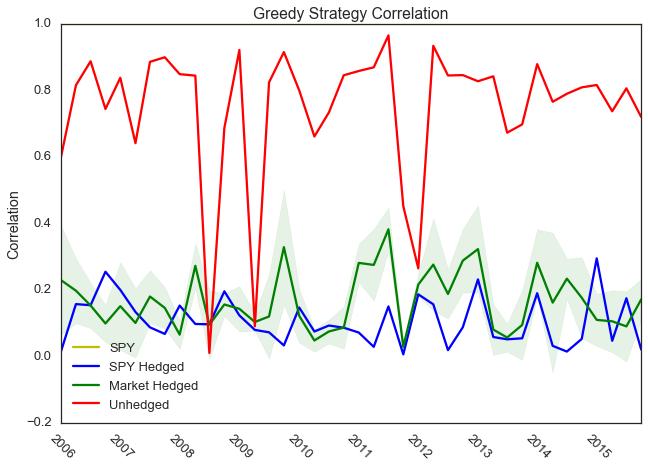

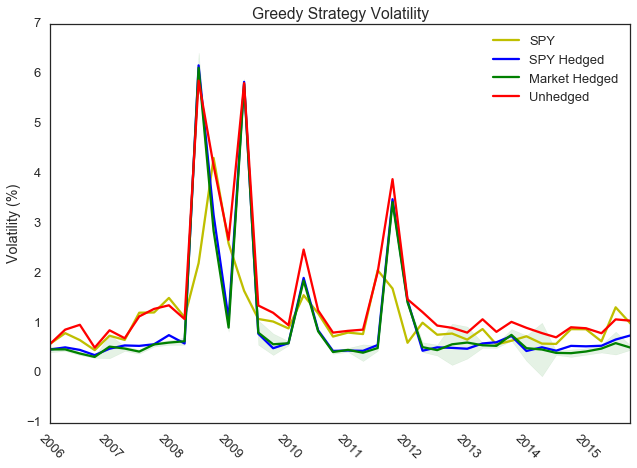

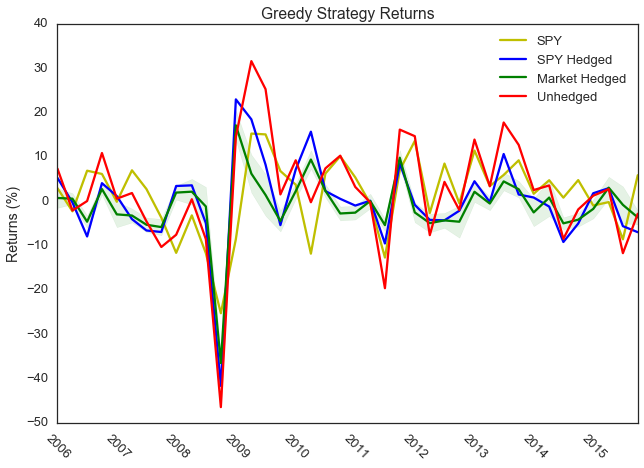

In [173]:
plot_from_df(mean_results_df, std_results_df, "Greedy Strategy")

In [168]:
def print_cum_returns(mean_results_df, title=""):
    spy_starting = 100
    market_starting = 100
    unhedged_starting = 100
    just_spy_starting = 100

    # dates = mean_results_df.index
    dates = [datetime.datetime.strptime(ii, '%Y-%m-%d') for ii in mean_results_df.index]

    length = len(dates)

    spy_returns = np.zeros(length)
    market_returns = np.zeros(length)
    unhedged_returns = np.zeros(length)
    just_spy_returns = np.zeros(length)

    for ii in range(length):
        spy_starting *= 1 + mean_results_df['spy_returns'][ii]/100.
        spy_returns[ii] = spy_starting
        
        market_starting *= 1 + mean_results_df['market_returns'][ii]/100.
        market_returns[ii] = market_starting
        
        unhedged_starting *= 1 + mean_results_df['unhedged_returns'][ii]/100.
        unhedged_returns[ii] = unhedged_starting
        
        just_spy_starting *= 1 + mean_results_df['just_spy_returns'][ii]/100.
        just_spy_returns[ii] = just_spy_starting
        
    plt.plot(dates, just_spy_returns, 'y', label="SPY")
    plt.plot(dates, unhedged_returns, 'r', label='Unhedged')
    plt.plot(dates, spy_returns, 'b', label="SPY hedged")
    plt.plot(dates, market_returns, 'g', label="Market hedged")
    plt.ylabel("% of Original Value")
    plt.legend(loc='best')
    plt.title(title+" Cumulative Returns")

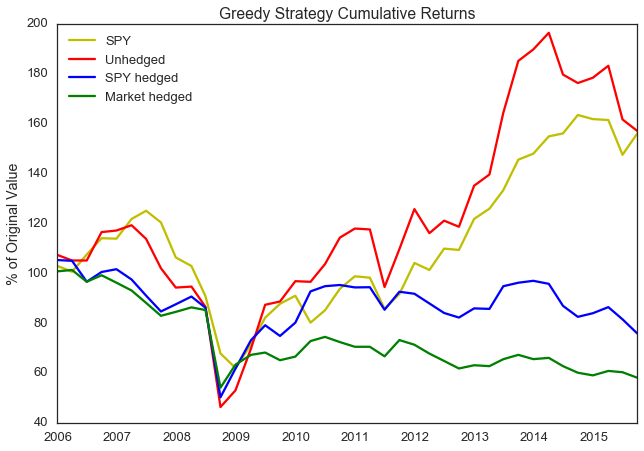

In [169]:
print_cum_returns(mean_results_df, "Greedy Strategy")

In [145]:
mean_results_df_low, std_results_df_low = ts_dfs('../../results/results_low_correlation/low_correlation_bestmarket_')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


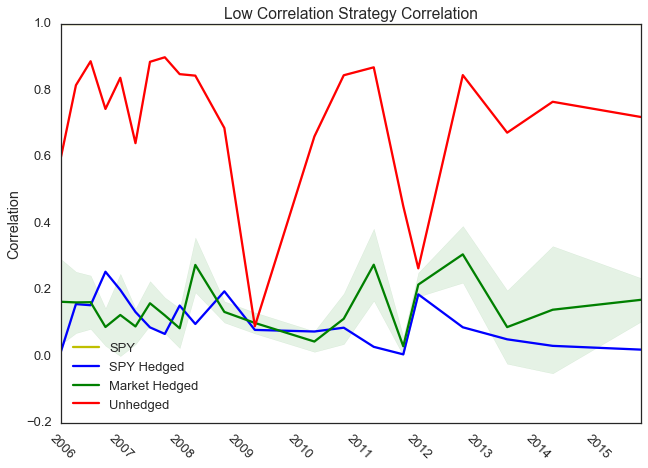

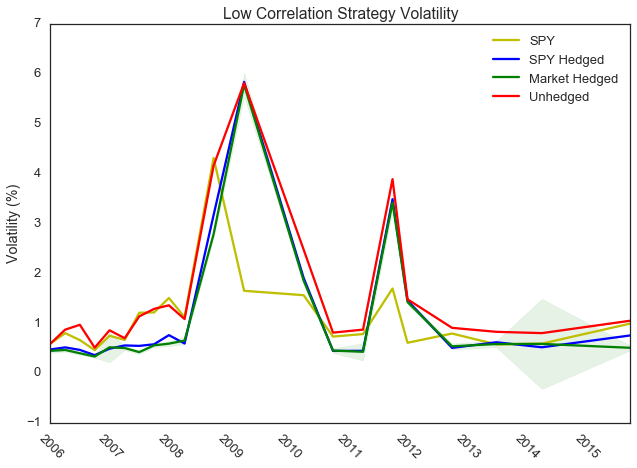

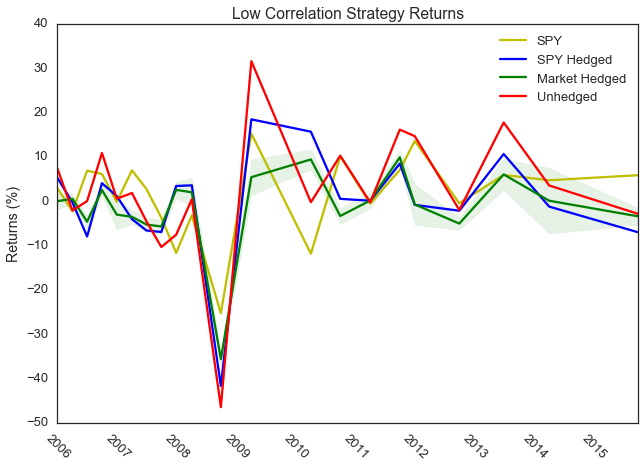

In [174]:
plot_from_df(mean_results_df_low, std_results_df_low, "Low Correlation Strategy")

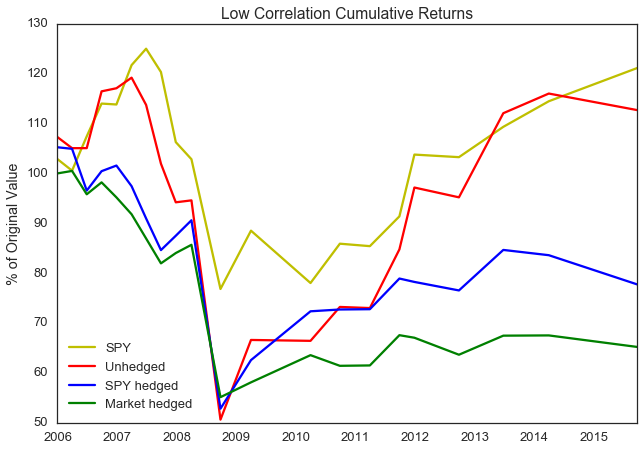

In [170]:
print_cum_returns(mean_results_df_low, "Low Correlation")